In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv("df_desc_main.csv")
df.head(1)

,molecule_chembl_id,smiles,IC50,standard_units,pIC50,MW,HBA,HBD,LogP,TPSA,...,bit_1014,bit_1015,bit_1016,bit_1017,bit_1018,bit_1019,bit_1020,bit_1021,bit_1022,bit_1023
0,CHEMBL432519,CC1=C(O)C(=O)C=C2C1=CC=C1[C@@]2(C)CC[C@@]2(C)[...,61600.0,nM,4.21,420.266445,3,1,6.4219,54.37,...,0,0,0,0,0,1,0,0,0,0


In [4]:
df['RotBonds']

0      0
1      1
2      4
3      5
4      4
      ..
803    3
804    2
805    4
806    3
807    3
Name: RotBonds, Length: 808, dtype: int64

In [5]:
X = df[['MW','HBA', 'HBD', 'LogP', 'TPSA','RotBonds']+ [col for col in df.columns if "bit_" in col]]
y = df["pIC50"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
models = {"lr": LinearRegression(),
          "svr": SVR(),
          "rf": RandomForestRegressor(random_state=101),
          "gb": GradientBoostingRegressor(random_state=101),
          "xgb": XGBRegressor(random_state=101)
          }

In [8]:
results = {}

for name, model in models.items():
    cv_scores = cross_val_score(model,X_train_scaled,y_train,scoring="r2",cv=10,n_jobs=-1)
    model.fit(X_train_scaled,y_train)

    y_pred = model.predict(X_test_scaled)
    r2 = r2_score(y_test,y_pred)
    mae = mean_absolute_error(y_test,y_pred)
    rmse = root_mean_squared_error(y_test,y_pred)

    results[name] = {
        "cv_score_mean": cv_scores.mean(),
        "cv_std": cv_scores.std(),
        "r2_result": r2,
        "mae": mae,
        "rmse": rmse
    }


for model_name, metrics in results.items():
    print(f"\n{model_name} Results:")
    for metric_name, values in metrics.items():
        print(f"{metric_name}: {values:.3f}")


lr Results:
cv_score_mean: -26428788537548108933890048.000
cv_std: 25731408396324097857945600.000
r2_result: -438570734795291492352.000
mae: 17132094884.143
rmse: 26982783626.036

svr Results:
cv_score_mean: 0.665
cv_std: 0.052
r2_result: 0.624
mae: 0.547
rmse: 0.790

rf Results:
cv_score_mean: 0.742
cv_std: 0.066
r2_result: 0.733
mae: 0.470
rmse: 0.666

gb Results:
cv_score_mean: 0.739
cv_std: 0.054
r2_result: 0.700
mae: 0.514
rmse: 0.706

xgb Results:
cv_score_mean: 0.719
cv_std: 0.055
r2_result: 0.704
mae: 0.500
rmse: 0.701


In [9]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt','log2'],
    'bootstrap': [True, False]
}


random_rf = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_dist,
                                   n_iter=100, cv=5, scoring='r2', verbose=2, random_state=101, n_jobs=-1)

random_rf.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\USER\anaconda3\envs\streamlitenv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
185 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
151 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\USER\anaconda3\envs\streamlitenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\USER\anaconda3\envs\streamlitenv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\USER\anaconda3\envs\streamlitenv\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_par

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=101, scoring='r2', verbose=2)

In [10]:
random_rf.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [11]:
y_pred = random_rf.predict(X_test_scaled)

In [13]:
print(f"'R2': {r2_score(y_test,y_pred)}")
print(f"'rmse': {root_mean_squared_error(y_test,y_pred)}")
print(f"'mae':{mean_absolute_error(y_test,y_pred)}")

'R2': 0.7632738440560979
'rmse': 0.6268881341515857
'mae':0.4425132763540714


Components: 50, r2_score: 0.715
Components: 100, r2_score: 0.703
Components: 150, r2_score: 0.680
Components: 200, r2_score: 0.662
Components: 250, r2_score: 0.639
Components: 300, r2_score: 0.625
Components: 400, r2_score: 0.596


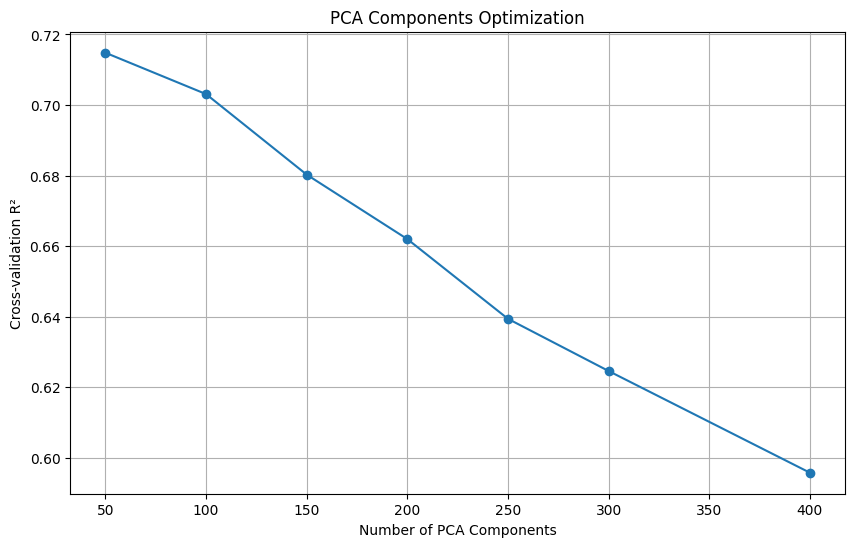

In [18]:
rf = RandomForestRegressor(n_estimators=500,min_samples_split=2,min_samples_leaf=1,max_features="sqrt",max_depth=40,bootstrap=False)
n_components_range = [50,100,150,200,250,300,400]
pca_score = []

for n in n_components_range:
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_train_scaled)
    score = cross_val_score(rf,X_pca,y_train,cv=5,scoring="r2",n_jobs=-1).mean()
    pca_score.append(score)
    print(f"Components: {n}, r2_score: {score:.3f}")

plt.figure(figsize=(10,6))
plt.plot(n_components_range,pca_score,marker="o")
plt.xlabel('Number of PCA Components')
plt.ylabel('Cross-validation R²')
plt.title('PCA Components Optimization')
plt.grid(True)
plt.show()


In [21]:
xgb = XGBRegressor(random_state=101)

stacking_model = StackingRegressor(
    estimators = [
        ("rf",rf),
        ("xgb",xgb)
    ],
    final_estimator=SVR(),
    passthrough = False
)

stacking_model.fit(X_train_scaled,y_train)
y_pred_stack = stacking_model.predict(X_test)
stacking_r2 = r2_score(y_test,y_pred_stack)

c:\Users\USER\anaconda3\envs\streamlitenv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [22]:
stacking_r2

0.3448356584051089

In [23]:
stacking_model = StackingRegressor(
    estimators = [
        ("rf",rf),
        ("xgb",xgb)
    ],
    final_estimator=rf,
    passthrough = False
)

stacking_model.fit(X_train_scaled,y_train)
y_pred_stack = stacking_model.predict(X_test)
stacking_r2 = r2_score(y_test,y_pred_stack)

c:\Users\USER\anaconda3\envs\streamlitenv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [24]:
stacking_r2

0.32038866339972416

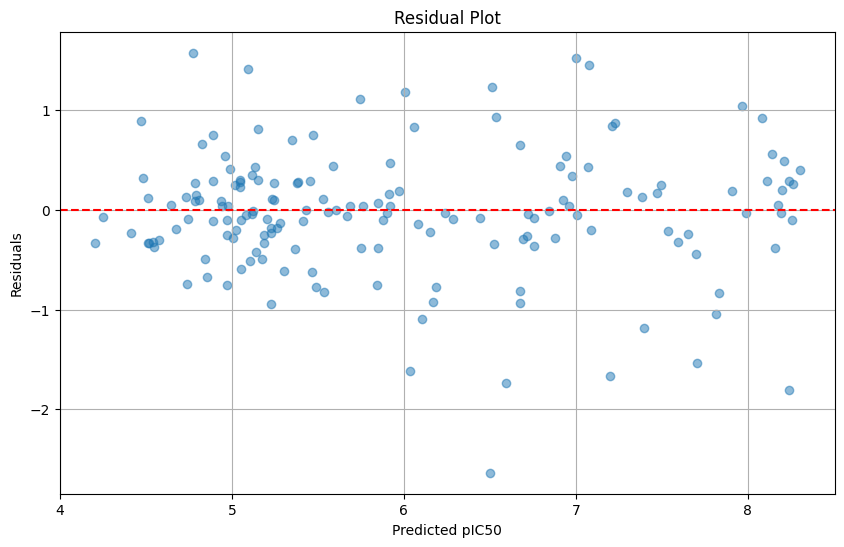

In [14]:
residuals = y_test - y_pred

plt.figure(figsize=(10,6))
plt.scatter(y_pred,residuals,alpha=0.5)
plt.axhline(y=0,color='r',linestyle='--')
plt.xlabel("Predicted pIC50")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

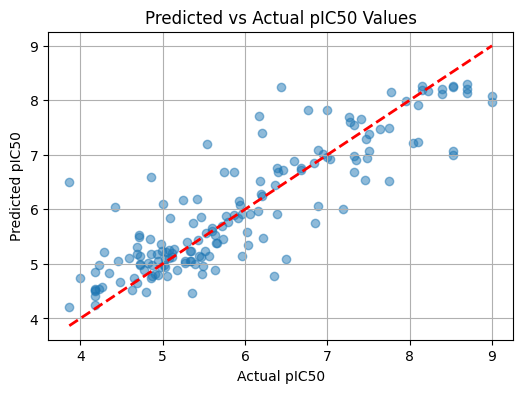

In [15]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Predicted vs Actual pIC50 Values')
plt.grid(True)
plt.show()

In [16]:
mae = mean_absolute_error(y_test, y_pred)
confidence_interval = 1.96 * mae
print(f"\nPrediction Interval (±): {confidence_interval:.3f}")


Prediction Interval (±): 0.867


In [30]:
def y_scrambling(X, y, n_trials=105):
    # Our actual model performance
    base_score = r2_score(y_test, y_pred)
    random_scores = []
    
    print("Performing Y-scrambling test...")
    for i in range(n_trials):
        # Shuffle y values randomly
        y_random = np.random.permutation(y)
        
        # Split data
        X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(
            X, y_random, test_size=0.2, random_state=i)
        
        # Train model with best parameters
        rf_rfe_random = RandomForestRegressor(n_estimators= 500,min_samples_split= 2,min_samples_leaf= 1,max_features='sqrt',max_depth=40,bootstrap= False, random_state=101)
        rf_rfe_random.fit(X_train_random,y_train_random)
        # Get score
        y_pred_random = rf_rfe_random.predict(X_test_random)
        score = r2_score(y_test_random, y_pred_random)
        random_scores.append(score)
        
        if (i + 1) % 10 == 0:
            print(f"Completed {i + 1} trials")
    
    # Print results
    print("\nY-scrambling Results:")
    print(f"Actual Model R²: {base_score:.3f}")
    print(f"Random Models R² (mean): {np.mean(random_scores):.3f}")
    print(f"Random Models R² (std): {np.std(random_scores):.3f}")
    
    # Plot distribution of random scores
    plt.figure(figsize=(10, 6))
    plt.hist(random_scores, bins=20, alpha=0.5, color='blue')
    plt.axvline(base_score, color='red', linestyle='--', label='Actual Model R²')
    plt.xlabel('R² Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Y-scrambling R² Scores')
    plt.legend()
    plt.show()

Performing Y-scrambling test...
Completed 10 trials
Completed 20 trials
Completed 30 trials
Completed 40 trials
Completed 50 trials
Completed 60 trials
Completed 70 trials
Completed 80 trials
Completed 90 trials
Completed 100 trials

Y-scrambling Results:
Actual Model R²: 0.770
Random Models R² (mean): -0.213
Random Models R² (std): 0.095


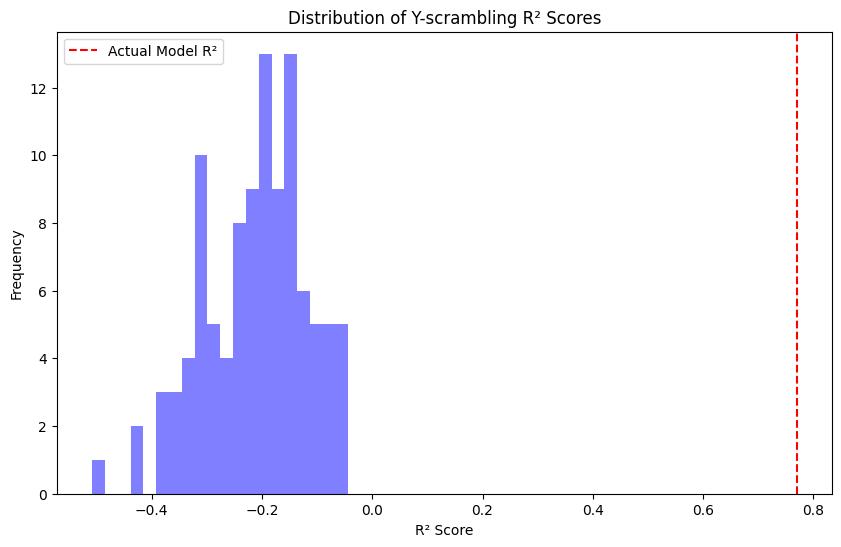

In [31]:
y_scrambling(X_train_scaled,y_train)

In [32]:
random_rf.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=40, max_features='sqrt',
                      n_estimators=500)

In [18]:
feature_names = ['MW','HBA', 'HBD', 'LogP', 'TPSA','RotBonds']+ [col for col in df.columns if "bit_" in col]
import pickle

model_components = { 
    'scaler': scaler,
    'feature_names': feature_names,
    'randomized_rf': random_rf.best_estimator_
}

with open("shp3_model_2.pkl", "wb") as f:
    pickle.dump(model_components,f)

print("Model components sucessfully saved")

Model components sucessfully saved
